In [1]:
!pip install pyarrow

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [5]:
df=pd.read_parquet('../data/green_tripdata_2021-01.parquet')

In [6]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [7]:
df.lpep_dropoff_datetime-df.lpep_pickup_datetime
df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
df.duration=df.duration.apply(lambda td: td.total_seconds()/60)
df
#View distribution of the duration
sns.distplot(df.duration)
#here we can see the counts, minimum duration, max duration
df.duration.describe()

#viewing percentile
df.duration.describe(percentiles=[0.95,0.98,0.99])

#98% of the trips are less 59 minutes
#Lets filter out the trips between 1 and 60 minutes
df=df[(df.duration>=1) & (df.duration<=60)]


#features
categorical=['PULocationID','DOLocationID']
numerical=['trip_distance']

df[categorical].dtypes

df[categorical]=df[categorical].astype(str)

df.dtypes

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Length: 76518, dtype: timedelta64[ns]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

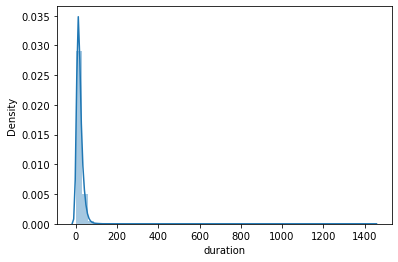

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [15]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


PULocationID    int64
DOLocationID    int64
dtype: object

/tmp/ipykernel_4291/303441284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical]=df[categorical].astype(str)


VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [20]:
#converts each datafram into a dictionary
train_dicts=df[categorical+numerical].to_dict(orient='records')
#one hot encoding for categorical features converts categorical to numeric ones

#converts dictionary to vector
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)

target='duration'
y_train=df[target].values

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_train)
mean_squared_error(y_train,y_pred,squared=False)

In [23]:
dv.feature_names_
#one hot encoding is done.. each location id becomes a feature

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [25]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

LinearRegression()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

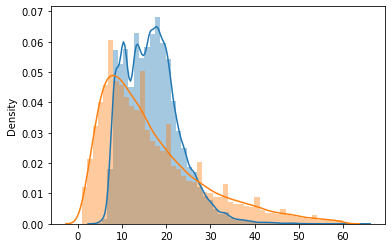

In [28]:
sns.distplot(y_pred,label='prediction')
sns.distplot(y_train,label='actual')

9.775464552087287

In [31]:
def read_dataframe(filename):
    df=pd.read_parquet(filename)
    df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda td: td.total_seconds()/60)
    df
    #View distribution of the duration
    sns.distplot(df.duration)
    #here we can see the counts, minimum duration, max duration
    df.duration.describe()

    #viewing percentile
    df.duration.describe(percentiles=[0.95,0.98,0.99])

    #98% of the trips are less 59 minutes
    #Lets filter out the trips between 1 and 60 minutes
    df=df[(df.duration>=1) & (df.duration<=60)]


    #features
    categorical=['PULocationID','DOLocationID']
    numerical=['trip_distance']

    df[categorical].dtypes

    df[categorical]=df[categorical].astype(str)

    df.dtypes
    return df

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


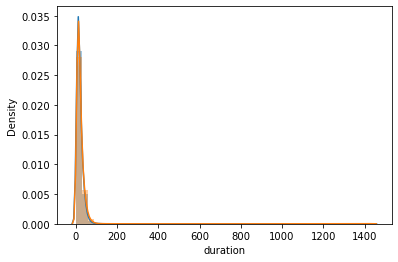

In [32]:
df_train=read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val=read_dataframe('../data/green_tripdata_2021-02.parquet')

In [36]:
(len(df_train),len(df_val))


(73908, 61921)

In [38]:
#features
categorical=['PULocationID','DOLocationID']
numerical=['trip_distance']
#converts dictionary to vector
dv=DictVectorizer()

#converts each datafram into a dictionary
train_dicts=df_train[categorical+numerical].to_dict(orient='records')
#one hot encoding for categorical features converts categorical to numeric ones


X_train=dv.fit_transform(train_dicts)

#Validation Dataset
val_dicts=df_val[categorical+numerical].to_dict(orient='records')
X_val=dv.transform(val_dicts)




In [39]:
target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [40]:

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)
mean_squared_error(y_val,y_pred,squared=False)

10.473871267670901

In [41]:

lr=Lasso()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)
mean_squared_error(y_val,y_pred,squared=False)

12.212583224318818